(400, 400)


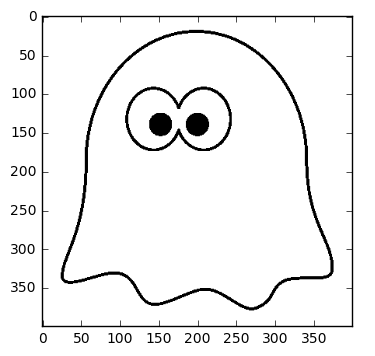

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import colorsys
from PIL import Image

#img = Image.open('dragon_200.png')
#img = Image.open('pattern.png')
img = Image.open('ghost_400.png')
img = img.convert('RGB')

print(img.size)
plt.imshow(img)


In [71]:
TILE_SIZE = 10 # Size of the tile => 10x10
BITS = 1       # Color depth

class Tile:
    def get_pixel(self, x, y):
        return self.pixels[x][y]
    
    def to_binary(self):
        if (BITS == 8):
            binary = [bin(x)[2:].zfill(8) for x in self.pixels.flatten()]
            return np.array([list(map(int, x)) for x in binary]).flatten()
        if (BITS == 1):
            binary = []
            for x in self.pixels.flatten():
                assert(x == 255 or x == 0)
                binary.append(x // 255)
            return np.array(binary)
    
    def __init__(self, pixels):
        self.pixels = pixels
        
def tile_equals(tile1, tile2):
    return np.array_equal(tile1.pixels.flatten(), tile2.pixels.flatten())


In [72]:
WIDTH = img.size[0]
HEIGHT = img.size[1]

tiles_x = WIDTH // TILE_SIZE
tiles_y = HEIGHT // TILE_SIZE

def get_tiles_from_img(img):
    img_data = np.array(img.getdata()).reshape(WIDTH, HEIGHT, 3) 
    print("Img data shape: ", img_data.shape)
    
    tiles = []
    for x in range(tiles_x):
        for y in range(tiles_y):
            pixels = []
            count = 0
            for offset_x in range(TILE_SIZE):
                for offset_y in range(TILE_SIZE):
                    pixels.append(img_data[x * TILE_SIZE + offset_x][y * TILE_SIZE + offset_y])
                
            tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    
    return np.array(tiles)

In [73]:
def show_tiles(tiles):
    reshaped_tiles = tiles.reshape(tiles_x, tiles_y)
    pixels = np.empty([WIDTH, HEIGHT, 3])
    for x in range(tiles_x):
        for y in range(tiles_y):
            for offset_x in range(TILE_SIZE):
                for offset_y in range(TILE_SIZE):
                    tile = reshaped_tiles[x][y]
                    pixels[x * TILE_SIZE + offset_x][y * TILE_SIZE + offset_y] = tile.get_pixel(offset_x, offset_y)
    
    im = Image.fromarray(np.uint8(pixels).reshape(HEIGHT, WIDTH, 3))
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title('Original')
    
    plt.subplot(1,2,2)
    plt.imshow(im)
    plt.title('Predicted')
    
def to_color_depth_8(binary):
    r = binary[0:BITS]
    g = binary[BITS:2*BITS]
    b = binary[2*BITS:3*BITS]

    if (BITS == 1):
        if ((r + g + b)[0] >= 2):
            return [255, 255, 255]
        else:
            return [0, 0, 0]
        
    if (BITS == 8):
        result = []
        for color in [r, g, b]:
            binar = map(str, color)
            result.append(int(''.join(binar), 2))
        return result

def predicted_to_tiles(predicted):
    tiles = []
    for pred in predicted:
        reshaped = pred.reshape(TILE_SIZE * TILE_SIZE, 3, BITS)
        pixels = [to_color_depth_8(x.flatten()) for x in reshaped]
        tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    return np.array(tiles)

In [74]:
assert(WIDTH % TILE_SIZE == 0 and HEIGHT % TILE_SIZE == 0)

In [75]:
tiles = get_tiles_from_img(img)

train_x = [t.to_binary() for t in tiles]
train_y = np.copy(train_x)

Img data shape:  (400, 400, 3)


In [76]:
from scipy import misc
HIDDEN_1 = 2
HIDDEN_2 = 4
throughput = 0
for i in range(HIDDEN_1 + 1):
    throughput += misc.comb(HIDDEN_2, i, exact=1)
print("Max throughput (between two hidden layers): ", throughput)

Max throughput (between two hidden layers):  11


In [77]:
def get_model_score(tiles, tiles_predicted):
    error = 0
    for i in range(len(tiles)):
        error += sum([1 for x in (tiles[i].pixels.flatten() - tiles_predicted[i].pixels.flatten()) if x != 0])
    return float(error) / (len(tiles) * TILE_SIZE * TILE_SIZE * 3 * BITS)

Model score (train data):  0.9660125


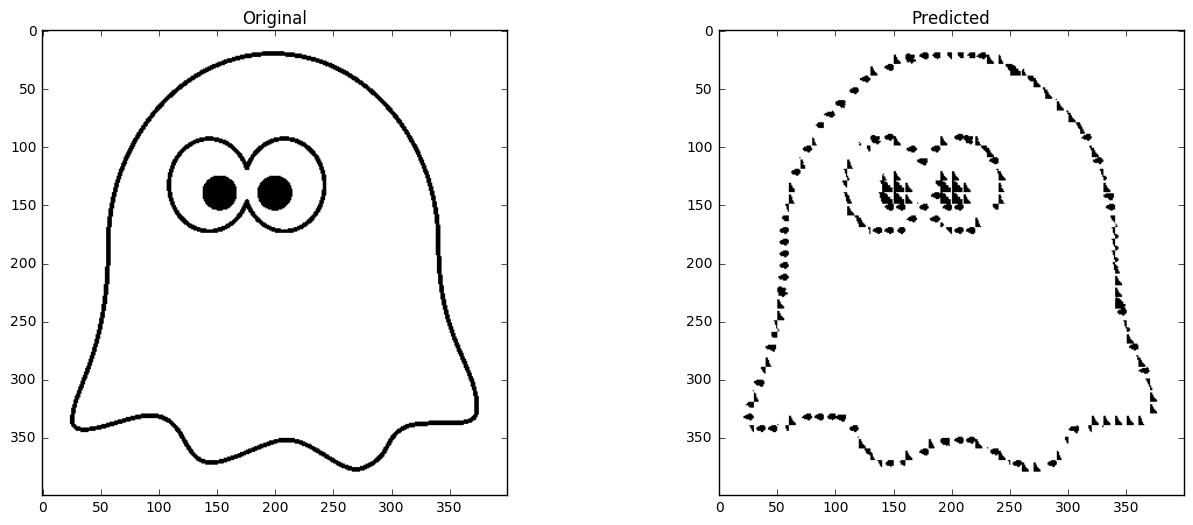

In [78]:
from sklearn import neural_network as nn
clf = nn.MLPClassifier(hidden_layer_sizes=(HIDDEN_1, HIDDEN_2),
                       activation='relu',
                       solver='adam',
                       alpha=0.0001,
                       shuffle=True,
                       verbose=False,
                       warm_start=False,
                       tol=0.00001,
                       max_iter=1000,
                       learning_rate='constant',
                       learning_rate_init=0.001)

model = clf.fit(train_x, train_y)
predicted = model.predict(train_x)
tiles_predicted = predicted_to_tiles(predicted)

print("Model score (train data): ", 1 - get_model_score(tiles, tiles_predicted))
      
show_tiles(tiles_predicted)

Used tile types:  76


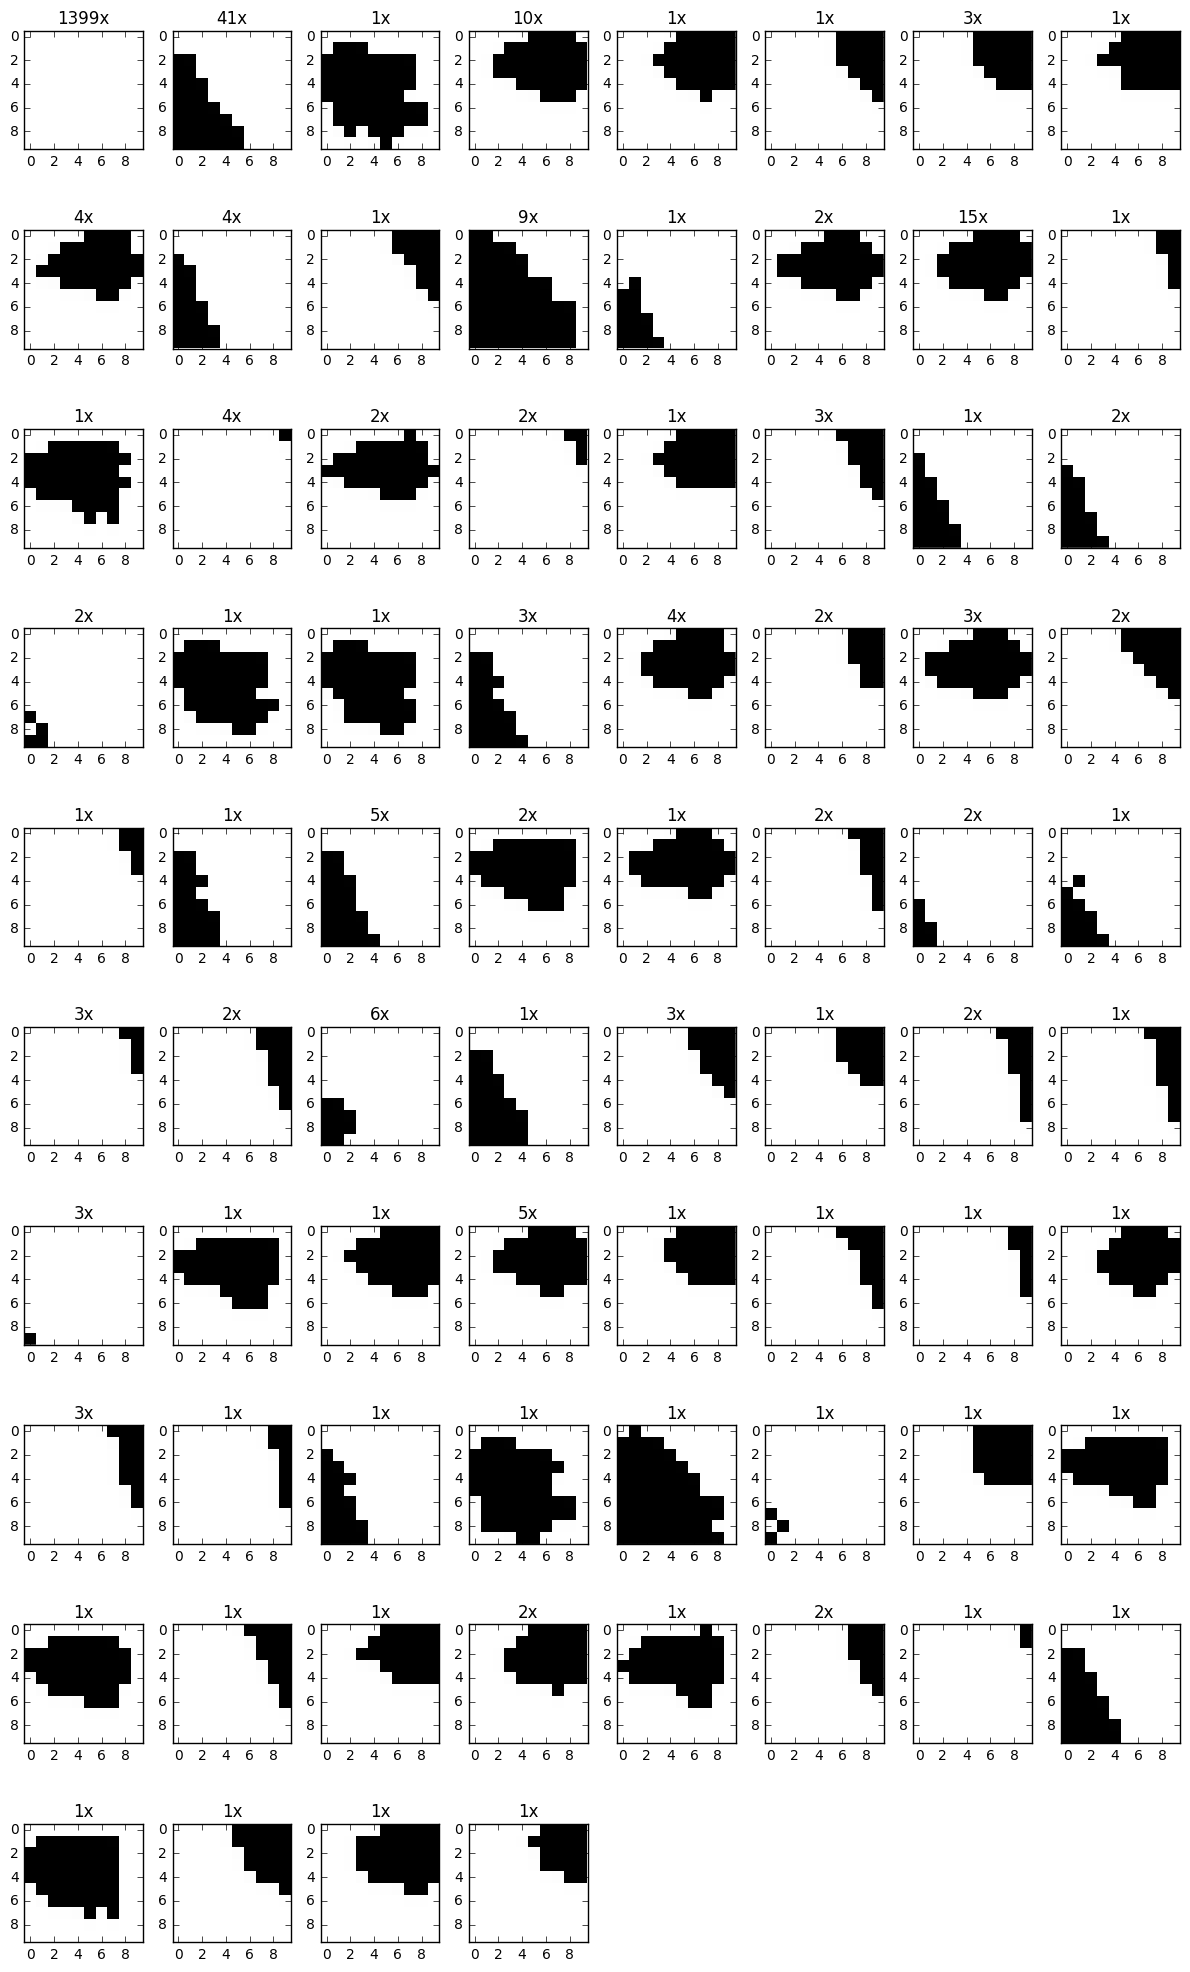

In [79]:
unique_tiles = []

for t in tiles_predicted:
    used_tile = False
    for u in unique_tiles:
        if tile_equals(t, u):
            used_tile = True
            break
    if not used_tile:
        unique_tiles.append(t)

print("Used tile types: ", len(unique_tiles))
if (len(unique_tiles) > 120):
    print("Too many tiles to show")
else:
    tile_counts = np.array([0] * len(unique_tiles))
    for i in range(len(tile_counts)):
        for t in tiles_predicted:
            if (tile_equals(t, unique_tiles[i])):
                tile_counts[i] += 1
    
    plt.figure(figsize=(12, 30))
    for i in range(1, len(unique_tiles) + 1):
        im = Image.fromarray(np.uint8(unique_tiles[i-1].pixels))
        plt.subplot(15,8,i)
        title = "{}x".format(tile_counts[i-1])
        plt.title(title)
        plt.imshow(im, interpolation='none')
        
    plt.tight_layout()

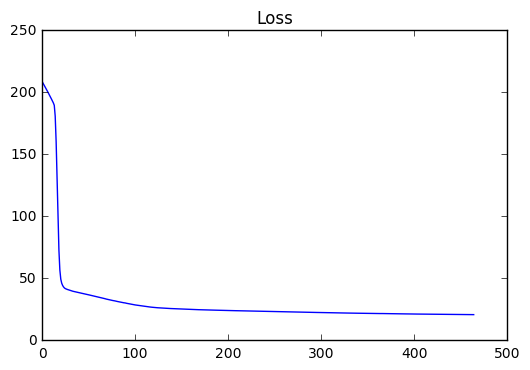

In [80]:
plt.plot(model.loss_curve_)
plt.title('Loss')

## Throughput
Throughput of the network at the point where the network extends (layer i -> j): 

$ n = \text{size of j (bigger layer)  } k = \text{size of i (smaller layer)} $

$$ \sum_{i=0}^{k} {n \choose i} $$